#**Stack Labs - Pandas Squad - Segmentação de Clientes - olist**

---



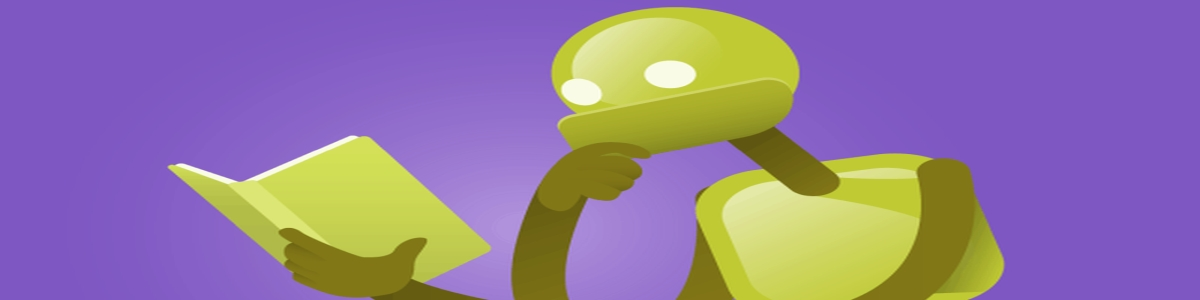

##**Índice:**

1. [Definição do Projeto](#olist)
2. [Análise Geospacial](#geospacial)
3. [Análise de Séries Temporais](#seriestemporais)
4. [Análise RFM - Pontuação](#pontuacao)
5. [Análise RFM - Segmentos](#segmentos)
6. [Análise RFM - Plano de Fidelidade](#fidelidade)
7. [Análise RFM - Visualização 3D](#plot3d)
8. [Referências](#referencias)



<a name="olist"></a>
#**Quem é a olist?**


**O olist store é o modelo de vendas no qual os produtos dos parceiros são listados dentro da loja do Olist nos maiores marketplaces do Brasil e outros canais relevantes do e-commerce.**

#**Como é o esquema da olist?**

In [ ]:
from IPython.display import Image
Image(url='https://growth-mkt-blog-wp-uploads.s3.amazonaws.com/uploads/2021/03/voce-com-olist.gif')

#**Por que é importante analisar a olist?**

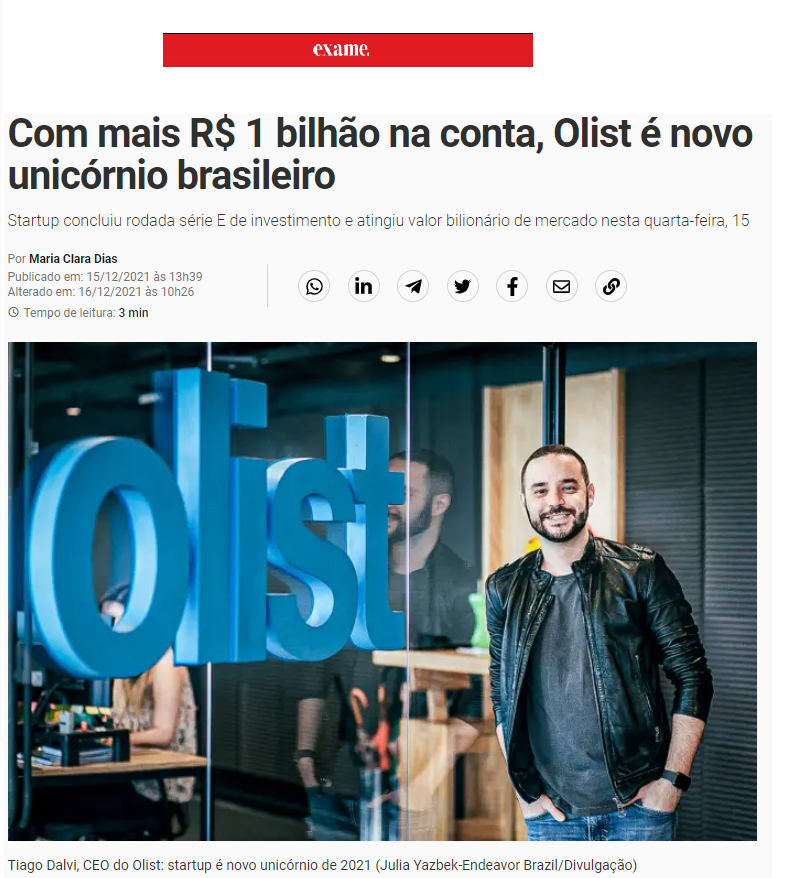

<a name='problem_definition'></a>
#**Definição do problema**
 Este projeto utiliza um conjunto de dados público, do comércio eletrônico brasileiro, de pedidos feitos na Olist Store.
A base está disponível no [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce).

- Começaremos fazendo uma análise exploratória dos dados para extrair o maximo de conhecimento da nossa base.
- Precisamos fazer uma análise Geospacial para poder visualizar a distribuição de nossos pedidos pelo Brasil todo. 
- O desafio é segmentar os clientes utilizando o conceito de RFM(Recência, Frequência e Monetária), que será explicado mais a fundo ao longo da nossa explanação.
- Nosso objetivo é dividir os grupos de consumidores por pontuação e segmentos, e assim poder tomar decisões efetivas, específicas para cada tipo de cliente.
- Queremos também criar um Clube de Fidelidade, e para isso precisamos dividir nossos clientes em categorias para futuros benefícios (Platinum, Gold, Silver, Bronze).
- Por último, e não menos importante, precisamos gerar diversos gráficos e mapas para montar um relatório gerencial, que será apresentado na forma de um DashBoard na aplicação final.



**Diagrama de Dados:**

<img src="https://i.imgur.com/HRhd2Y0.png" width=760 height=760 />


<a id='data_analysis'></a>
## Conhecendo a Base de Dados


In [ ]:
# montando o Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# path relativo ao projeto
path_relativo = "/content/drive/MyDrive/Ciência de Dados/StackLabs/"

In [ ]:
# instala as dependencias das bibliotecas
!pip install -r "/content/drive/MyDrive/Ciência de Dados/StackLabs/requirements.txt"

In [ ]:
#importa as bibliotecas
import pandas as pd
import urllib
import json
import unidecode
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
#configuracao dos tamanhos dos graficos seaborn
sns.set(rc={'figure.figsize':(15.7,12.27)})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carrega as tabelas que vamos utilizar do banco de dados

In [ ]:
# carrega os primeiras tabelas que vamos uitilizar
customers = pd.read_csv(path_relativo + 'database/olist_customers_dataset.csv')
geolocation = pd.read_csv(path_relativo + 'database/olist_geolocation_dataset.csv')
orders = pd.read_csv(path_relativo + 'database/olist_orders_dataset.csv')
order_items = pd.read_csv(path_relativo + 'database/olist_order_items_dataset.csv')


<a name='geospacial'></a>
# Análise Geoespacial do E-Commerce Brasileiro

A Olist lançou um conjunto de dados com 100 mil pedidos feitos entre 2016 e 2018. Cada pedido contém algumas informações sobre o cliente e contém os três primeiros dígitos do código postal do cliente. A Olist também lançou um banco de dados de geolocalização que tem 323 mil coordenadas lat / lng relacionadas aos três primeiros dígitos de cada código postal.

Eles publicaram também um estudo completo, em português, sobre a logística brasileira. [Leia aqui.](Https://engineering.olist.com/por-que-suas-compras-online-atrasam-d4cf9df8c4d0)

## CEP do Brasil:
Um código postal brasileiro, também conhecido como CEP, significa Código de Endereço Postal (* Código de Endereço Postal *) e contém 8 dígitos. Introduzido em 1972 como uma sequência de cinco dígitos, foi expandido para oito dígitos em 1992 para permitir uma localização mais precisa. O formato padrão é "nnnnn-nnn" (os cinco dígitos originais, um hífen e os novos três dígitos).

** CEP: ** 12.345-678

A maioria das cidades com população em torno de 100.000 ou mais tem um CEP atribuído a todos os locais públicos e a alguns espaços privados de alta ocupação, como grandes edifícios comerciais e grandes condomínios residenciais. As cidades pequenas recebem um código geral de 5 dígitos seguido do sufixo -000.

* a primeira parte é composta por 5 dígitos que representam Região, Sub-região, Setor, Subsetor e Subsetor Divisor.
* a segunda parte contém 3 dígitos, separados por um hífen da primeira, e representa os Identificadores de Distribuição.

Mais informações sobre o funcionamento do CEP podem ser encontradas no [site dos Correios](https://www.correios.com.br/a-a-z/cep-codigo-de-enderecamento-postal).

Vamos dar uma olhada no conjunto de dados de geolocalização fornecido pela Olist e tentar entender como o CEP funciona geograficamente.

**Geolocalização:**

In [ ]:
geolocation.sample(5)

geolocation_zip_code_prefix  ...  geolocation_state
835300                        79020  ...                 MS
488879                        25730  ...                 RJ
528106                        29010  ...                 ES
896405                        87320  ...                 PR
62421                          3607  ...                 SP

[5 rows x 5 columns]

Não há valores nulos para clientes

In [ ]:
geolocation.isna().mean()

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

Como podemos ver, existem duplicatas da cidade com acentos nos nomes.

In [ ]:
geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [ ]:
def pretty_string(column):
    column_space = ' '.join(column.split())
    return unidecode.unidecode(column_space.lower())

In [ ]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(pretty_string)

Como podemos ver, existe o mesmo prefixo de código postal com mais de 1 local. Esse problema pode ter ocorrido porque apenas o prefixo do código postal foi mantido. Para resolver este problema usaremos o valor mediano da latitude e longitude de cada ponto

In [ ]:
geolocation.groupby('geolocation_zip_code_prefix').size().sort_values(ascending=False)

geolocation_zip_code_prefix
24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
63012       1
63042       1
63103       1
13176       1
11374       1
Length: 19015, dtype: int64

In [ ]:
geolocation[geolocation['geolocation_zip_code_prefix'] == 22261].head()    

geolocation_zip_code_prefix  ...  geolocation_state
441967                        22261  ...                 RJ
441970                        22261  ...                 RJ
441976                        22261  ...                 RJ
441977                        22261  ...                 RJ
442045                        22261  ...                 RJ

[5 rows x 5 columns]

Existem 8 códigos postais com dois ou mais estados. Para resolver este problema, contaremos os estados por código postal e usaremos o estado majoritário para este código postal.

In [ ]:
other_state_geolocation = geolocation.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)

In [ ]:
geolocation_silver = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')

In [ ]:
customers_silver = customers.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

In [ ]:
def plot_brasil_map(data):
    brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10,10), alpha=0.3,s=0.3,c='blue')
    plt.axis('off')
    plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
    plt.show()

Como podemos ver, existem mais clientes nas regiões sudeste e sul do país. Outras informações, há mais clientes em cidades que são capitais (São Paulo, Rio de Janeiro, Porto Alegre e outras).

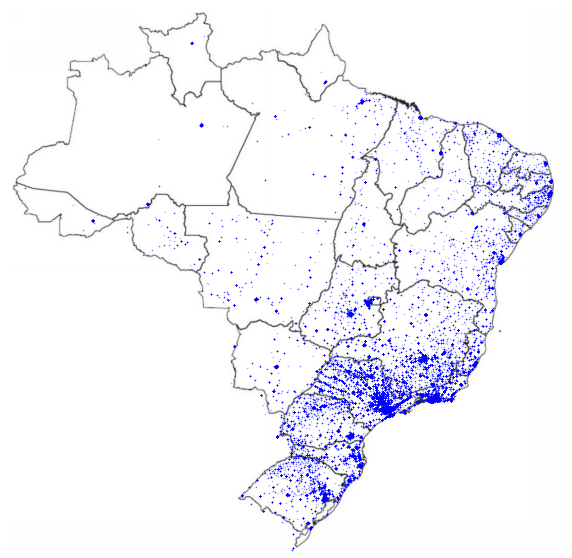

In [ ]:
plot_brasil_map(customers_silver.drop_duplicates(subset='customer_unique_id'))

**Mais Mapas:**

In [ ]:
import numpy as np
import pandas as pd 
import os

geo = pd.read_csv(path_relativo + "database/olist_geolocation_dataset.csv", dtype={'geolocation_zip_code_prefix': str})

# Gets the first three and four first digits of zip codes, we will explore this further to understand how zip codes works
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix'].str[0:1]
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix'].str[0:2]
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix'].str[0:3]
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix'].str[0:4]
geo.head(3)

geolocation_zip_code_prefix  ...  geolocation_zip_code_prefix_4_digits
0                       01037  ...                                  0103
1                       01046  ...                                  0104
2                       01046  ...                                  0104

[3 rows x 9 columns]

There are 19.051 different zip_code_prefix. On average there are 52.6 coordinates for each prefix. But there is one prefix with 1.146 coordinates available.

In [ ]:
geo['geolocation_zip_code_prefix'].value_counts().to_frame().describe()

geolocation_zip_code_prefix
count                 19015.000000
mean                     52.598633
std                      72.057907
min                       1.000000
25%                      10.000000
50%                      29.000000
75%                      66.500000
max                    1146.000000

Existem algumas coordenadas discrepantes no conjunto de dados que estão fora do território brasileiro. Vamos garantir que todas as coordenadas estão dentro de um retângulo delimitado pelos limites do Brasil.

In [ ]:
# Removendo outliers
#O ponto mais ao norte do Brasil é 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#O ponto mais ao oeste do Brasil é 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#O ponto mais ao sul do Brasil é 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#O ponto mais ao leste do Brasil é 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]

In [ ]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(geo.geolocation_lng, geo.geolocation_lat)
geo['x'] = pd.Series(x)
geo['y'] = pd.Series(y)

In [ ]:
geo.head(3)

geolocation_zip_code_prefix  geolocation_lat  ...             x             y
0                       01037       -23.545621  ... -5.191862e+06 -2.698137e+06
1                       01046       -23.546081  ... -5.192478e+06 -2.698193e+06
2                       01046       -23.546129  ... -5.192270e+06 -2.698199e+06

[3 rows x 11 columns]

## CEPs no Brasil
Finalmente traçando as coordenadas em um mapa. Vemos que existe uma relação entre o prefixo do código postal e a localização desse código postal. Começam em São Paulo, com prefixo 01001, e aumentam no sentido anti-horário, terminando no Rio Grande do Sul (sul do Brasil), com prefixo 99990.

In [ ]:
# transformando os prefixos para inteiros para calculos
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].astype(int)
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix_1_digits'].astype(int)
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix_2_digits'].astype(int)
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix_3_digits'].astype(int)
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix_4_digits'].astype(int)

In [ ]:
brazil = geo
agg_name = 'geolocation_zip_code_prefix'
brazil[agg_name].describe().to_frame()

geolocation_zip_code_prefix
count                 1.000121e+06
mean                  3.657332e+04
std                   3.054939e+04
min                   1.001000e+03
25%                   1.107500e+04
50%                   2.653000e+04
75%                   6.350400e+04
max                   9.999000e+04

In [ ]:
%matplotlib inline 
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


In [ ]:
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1

def plot_map(data, label, agg_data, agg_name, cmap):
    url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gv.WMTS(url)
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
hv.extension('bokeh')
plot_map(brazil, 'CEPs no Brasil', ds.min(agg_name), agg_name, cmap=rainbow)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import datashader as ds
from datashader import transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from IPython.core.display import HTML, display
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr

background = "black"
cm = partial(colormap_select, reverse=(background!="black"))
export = partial(export_image, background = background, export_path="export")
display(HTML("<style>.container { width:100% !important; }</style>"))
W = 700 

def create_map(data, cmap, data_agg, export_name='img'):
    pad = (data.x.max() - data.x.min())/50
    x_range, y_range = ((data.x.min() - pad, data.x.max() + pad), 
                             (data.y.min() - pad, data.y.max() + pad))

    ratio = (y_range[1] - y_range[0]) / (x_range[1] - x_range[0])

    plot_width  = int(W)
    plot_height = int(plot_width * ratio)
    if ratio > 1.5:
        plot_height = 550
        plot_width = int(plot_height / ratio)
        
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

    agg = cvs.points(data, 'x', 'y', data_agg)
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    return export(img, export_name)

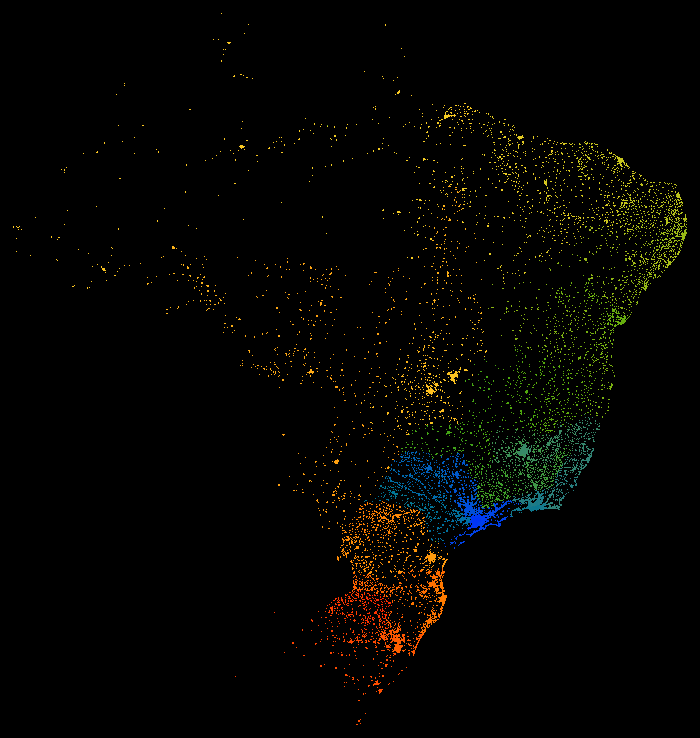

In [ ]:
create_map(brazil, rainbow, ds.mean(agg_name),'brazil_zip_codes')

## De onde vem a maior parte da receita?
Trabalhar com 5 dígitos de CEPs pode nos levar a amostras muito pequenas em algumas áreas, então trabalharemos com 3 dígitos. Traçando a soma dos valores dos produtos agrupados pelo prefixo do CEP, vemos que a maior parte da receita veio das regiões Sudeste e Sul do Brasil. Também é possível verificar que grandes cidades e capitais, onde a população é maior, têm maior participação na receita.

In [ ]:
orders_df = pd.read_csv(path_relativo + 'database/olist_orders_dataset.csv')
order_items = pd.read_csv(path_relativo + 'database/olist_order_items_dataset.csv')
order_reviews = pd.read_csv(path_relativo + 'database/olist_order_reviews_dataset.csv')
customer = pd.read_csv(path_relativo + 'database/olist_customers_dataset.csv', dtype={'customer_zip_code_prefix': str})

customer['customer_zip_code_prefix_3_digits'] = customer['customer_zip_code_prefix'].str[0:3]
customer['customer_zip_code_prefix_3_digits'] = customer['customer_zip_code_prefix_3_digits'].astype(int)

brazil_geo = geo.set_index('geolocation_zip_code_prefix_3_digits').copy()

In [ ]:
orders = orders_df.merge(order_items, on='order_id')
orders = orders.merge(customer, on='customer_id')
orders = orders.merge(order_reviews, on='order_id')

In [ ]:
gp = orders.groupby('customer_zip_code_prefix_3_digits')['price'].sum().to_frame()
revenue = brazil_geo.join(gp)
agg_name = 'revenue'
revenue[agg_name] = revenue.price / 1000

In [ ]:
hv.extension('bokeh')
plot_map(revenue, 'Receita de Pedidos (R$ milhares)', ds.mean(agg_name), agg_name, cmap=fire)

Output hidden; open in https://colab.research.google.com to view.

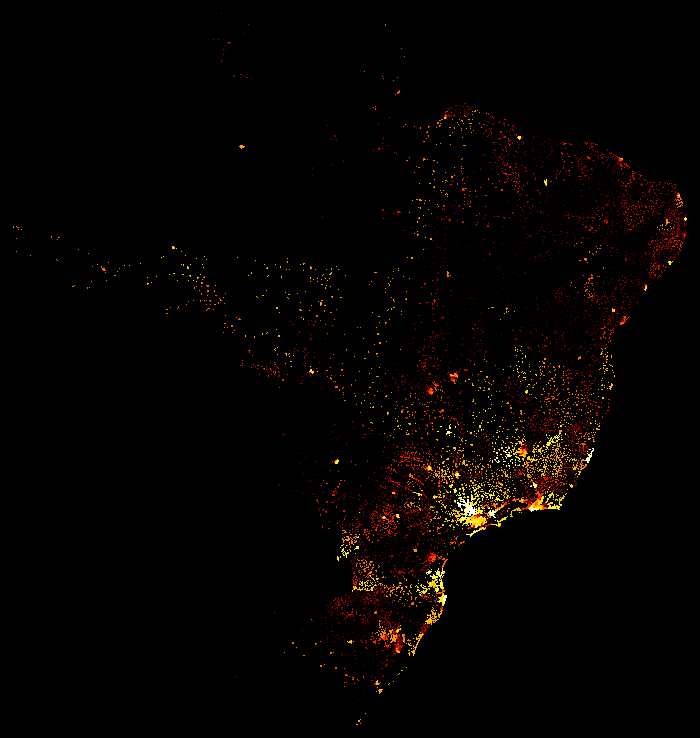

In [ ]:
create_map(revenue, fire, ds.mean(agg_name), 'revenue_brazil')

## Qual é o tíquete médio?
Aqui vemos algo inesperado. Os clientes das regiões Sul e Sudeste do Brasil apresentam tíquete médio inferior ao de seus pares das regiões Norte e Nordeste. Isso pode acontecer porque eles têm que pagar mais pelo frete (vamos verificar isso em um momento)

In [ ]:
gp = orders.groupby('order_id').agg({'price': 'sum', 'customer_zip_code_prefix_3_digits': 'max'})
gp = gp.groupby('customer_zip_code_prefix_3_digits')['price'].mean().to_frame()
avg_ticket = brazil_geo.join(gp)
agg_name = 'avg_ticket'
avg_ticket[agg_name] = avg_ticket.price

In [ ]:
plot_map(avg_ticket, 'Bilhete médio de pedidos (R $)', ds.mean(agg_name), agg_name, cmap=bgy)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (x_y avg_ticket)

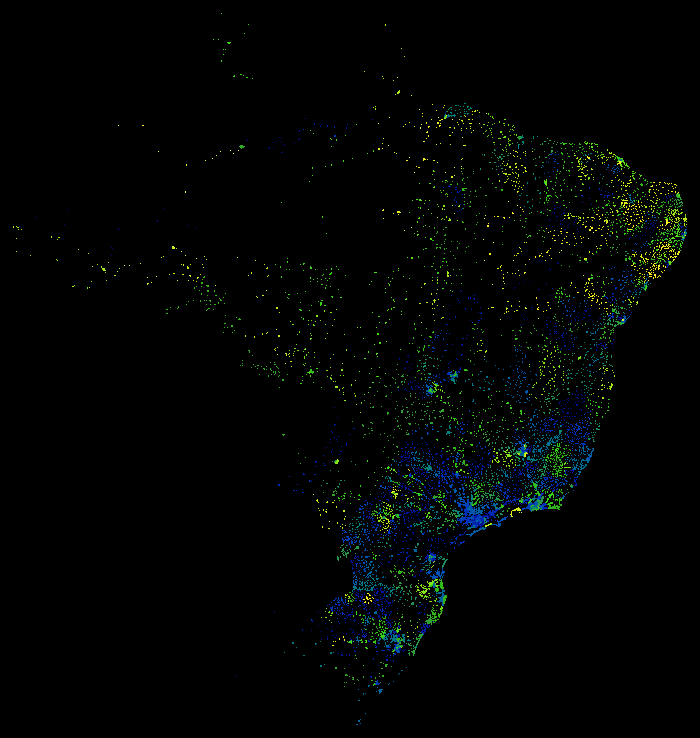

In [ ]:
create_map(avg_ticket, bgy, ds.mean('avg_ticket'), 'avg_ticket_brazil')

## Quem paga mais pelo transporte?
Podemos encontrar uma taxa de frete dividindo o valor do frete pelo valor do pedido. Essa proporção indica a porcentagem do preço do produto que uma pessoa teve que pagar apenas para ter seu pedido entregue. Por exemplo, se um produto custa R \ $ 50,00 e o valor do frete era R \ $ 10,00, a relação de frete é 0,2 ou 20%. Taxas de frete mais altas tendem a desencorajar os clientes a concluir uma compra. Devido aos custos de logística, esperamos ver taxas de frete mais baixas em áreas densamente povoadas e taxas de frete mais altas em regiões com poucas aves.

In [ ]:
gp = orders.groupby('order_id').agg({'price': 'sum', 'freight_value': 'sum', 'customer_zip_code_prefix_3_digits': 'max'})
agg_name = 'freight_ratio'
gp[agg_name] = gp.freight_value / gp.price
gp = gp.groupby('customer_zip_code_prefix_3_digits')[agg_name].mean().to_frame()
freight_ratio = brazil_geo.join(gp)

In [ ]:
plot_map(freight_ratio, 'Taxa de frete médio de pedidos', ds.mean(agg_name), agg_name, cmap=bgy)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (x_y freight_ratio)

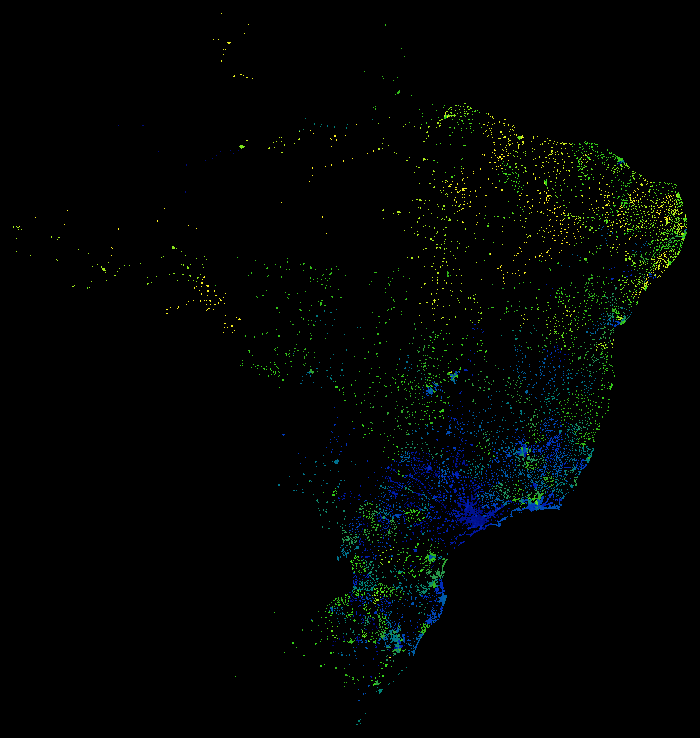

In [ ]:
create_map(freight_ratio, bgy, ds.mean('freight_ratio'), 'freight_ratio_brazil')

## Tempo médio de entrega
Infelizmente, quem mora no Norte e Nordeste do Brasil tem que arcar com custos de frete mais altos e tem que esperar mais para receber sua compra.

In [ ]:
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date)
orders['actual_delivery_time'] = orders.order_delivered_customer_date - orders.order_delivered_carrier_date
orders['actual_delivery_time'] = orders['actual_delivery_time'].dt.days

In [ ]:
gp = orders.groupby('customer_zip_code_prefix_3_digits')['actual_delivery_time'].mean().to_frame()
delivery_time = brazil_geo.join(gp)
agg_name = 'avg_delivery_time'
delivery_time[agg_name] = delivery_time['actual_delivery_time']

In [ ]:
hv.extension('bokeh')
plot_map(delivery_time, 'Tempo médio de entrega dos pedidos (dias)', ds.mean(agg_name), agg_name, cmap=bjy)

Output hidden; open in https://colab.research.google.com to view.

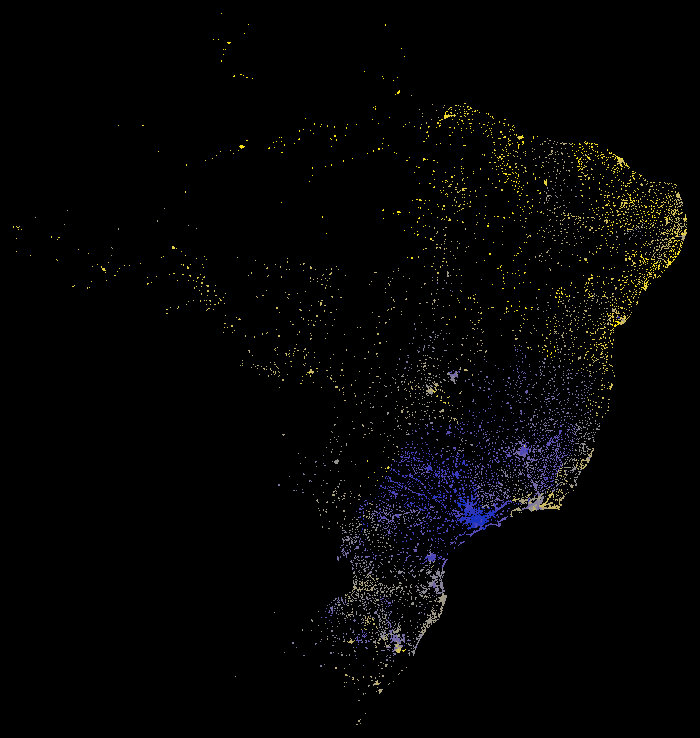

In [ ]:
create_map(delivery_time, bjy, ds.mean(agg_name), 'avg_delivery_time_brazil')

## Pedidos atrasados
Vamos medir a porcentagem de pedidos atrasados e ver como isso se relaciona com a pontuação dada pelos clientes?

In [ ]:
orders['is_delayed'] = orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date'] 
gp = orders.groupby('customer_zip_code_prefix_3_digits').agg({'is_delayed': ['sum', 'count']})
agg_name = 'delayed'
gp[agg_name] = gp['is_delayed']['sum'] / gp['is_delayed']['count']
gp = gp[agg_name]
order_delay = brazil_geo.join(gp)

In [ ]:
hv.extension('bokeh')
plot_map(order_delay, 'Porcentagem de atraso de pedidos no Brasil', ds.mean(agg_name), agg_name, cmap=bgy)

Output hidden; open in https://colab.research.google.com to view.

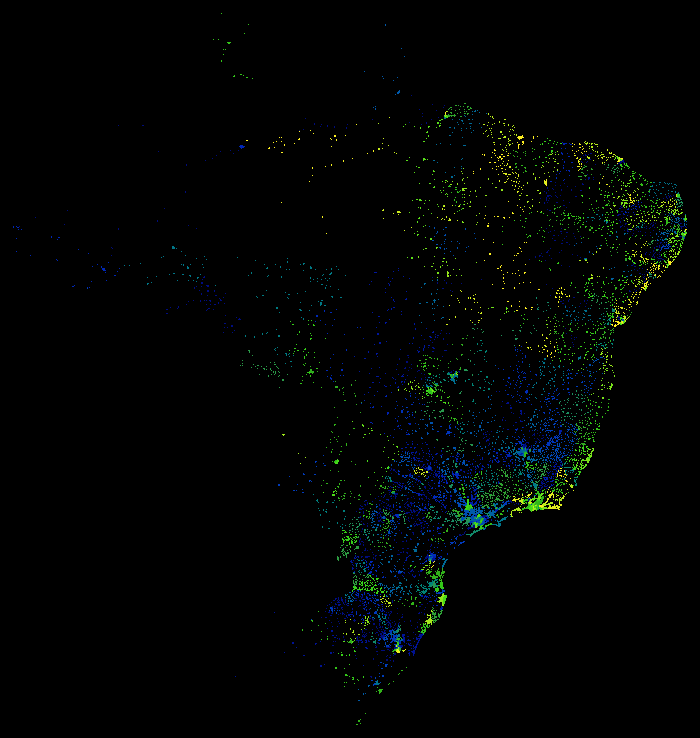

In [ ]:
create_map(order_delay, bgy, ds.mean(agg_name), 'brazil_order_delay_percentage')

<a name='seriestemporais'></a>
#**Análise de Séries Temporais**


## Carregando os Clientes

In [ ]:
customers.sample(5)

customer_id  ... customer_state
96770  c1958053622fd0bc2f0b7c06fa4ba179  ...             RJ
63408  a1fa003a1a17fc47164251e0e85034f7  ...             MA
36026  1adcfb4ea0149f959526939db0931e6a  ...             SP
42403  017dd3798ef0f401392abdbc129d78a0  ...             SP
58169  df82bea0664349eb5b8a7ef73871fc49  ...             BA

[5 rows x 5 columns]

Não há valores nulos para clientes

In [ ]:
customers.isna().mean()

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

Existem customer_unique_id duplicados, porque o conjunto de dados é por pedido. Onde client_id é a chave para o conjunto de dados do pedido. Cada pedido possui um client_id exclusivo.

In [ ]:
customers.groupby('customer_unique_id').size().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
                                    ..
a925c3e5df82fdc6082f1383d2834998     1
a92605ec492805540520d3a73aaeeb6e     1
a926aae38267e7f54e67de9b5775d0a5     1
a926cfc9bc7b082335de50450f48eec9     1
0000366f3b9a7992bf8c76cfdf3221e2     1
Length: 96096, dtype: int64

<a id='orders'></a>
## Carregando os Pedidos

In [ ]:
order_items.sample(5)

order_id  order_item_id  ...   price freight_value
64187   92a5191ba977547e2cd844d5140c63f1              2  ...   54.90          9.45
97733   ddbc3c65368eb9c4bcb2f1dc4feaea56              1  ...   23.99          7.78
31697   47e1801bc1f8eddb9969bf5fd8563712              1  ...  295.00         42.83
111920  fe468f428b8be30b4e7ca85901a35dac              1  ...   89.50         17.88
28679   414b227d34e12d2c95093f0bdb4c44bd              1  ...   39.99         17.14

[5 rows x 7 columns]

Não há valores nulos para order_items

In [ ]:
order_items.isna().mean()

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

Como podemos ver, um pedido pode ter mais de um produto.

In [ ]:
order_items.groupby('order_id').size().sort_values(ascending=False)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
a6e8ad5db31e71f5f12671af561acb4a     1
a6e963c11e80432334e984ead4797a8b     1
a6e9b80a7636eb8dd592dbb3e20d0a91     1
a6e9d106235bcf1dda54253686d89e99     1
00010242fe8c5a6d1ba2dd792cb16214     1
Length: 98666, dtype: int64

Como temos mais de 1 produto por pedido, precisamos somar o preço e o valor do frete e obter o valor máximo de shipping_limit_date para análise.

In [ ]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()

Como você pode ver, temos alguns valores discrepantes. como é que o frete está acima de R\$500 e qual pedido custa mais de R\$ 4000?

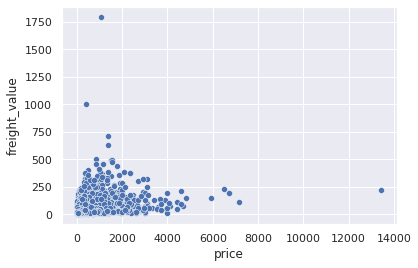

In [ ]:
sns.scatterplot(x='price',y='freight_value',data=order_items_silver)

Decidimos retirar pedidos com preço acima de R$5000 e para o valor do frete usamos a lógica como um valor que está longe do [percentil 99%](https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/).

In [ ]:
order_items_silver.describe()

price  freight_value
count  98666.000000   98666.000000
mean     137.754076      22.823562
std      210.645145      21.650909
min        0.850000       0.000000
25%       45.900000      13.850000
50%       86.900000      17.170000
75%      149.900000      24.040000
max    13440.000000    1794.960000

In [ ]:
percentil_freight_value = order_items_silver['freight_value'].quantile(0.99)
order_items_silver = order_items_silver[(order_items_silver['price'] <= 5000) & (order_items_silver['freight_value'] <= percentil_freight_value)]

Como podemos ver, o preço médio dos pedidos é de R\$132 e 50% dos pedidos custam menos de R\$85. O valor médio do frete é de R\$21,41 e 50% dos pedidos têm o valor do frete de R\$17.

In [ ]:
order_items_silver.describe()

price  freight_value
count  97679.000000   97679.000000
mean     132.046700      21.423227
std      185.015685      14.133667
min        0.850000       0.000000
25%       45.900000      13.790000
50%       85.000000      17.070000
75%      149.900000      23.700000
max     4690.000000     104.980000

In [ ]:
order_items_silver

order_id  ...  shipping_limit_date
0      00010242fe8c5a6d1ba2dd792cb16214  ...  2017-09-19 09:45:35
1      00018f77f2f0320c557190d7a144bdd3  ...  2017-05-03 11:05:13
2      000229ec398224ef6ca0657da4fc703e  ...  2018-01-18 14:48:30
3      00024acbcdf0a6daa1e931b038114c75  ...  2018-08-15 10:10:18
4      00042b26cf59d7ce69dfabb4e55b4fd9  ...  2017-02-13 13:57:51
...                                 ...  ...                  ...
98661  fffc94f6ce00a00581880bf54a75a037  ...  2018-05-02 04:11:01
98662  fffcd46ef2263f404302a634eb57f7eb  ...  2018-07-20 04:31:48
98663  fffce4705a9662cd70adb13d4a31832d  ...  2017-10-30 17:14:25
98664  fffe18544ffabc95dfada21779c9644f  ...  2017-08-21 00:04:32
98665  fffe41c64501cc87c801fd61db3f6244  ...  2018-06-12 17:10:13

[97679 rows x 4 columns]

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112372 entries, 0 to 112371
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   order_id                           112372 non-null  object        
 1   customer_id                        112372 non-null  object        
 2   order_status                       112372 non-null  object        
 3   order_purchase_timestamp           112372 non-null  object        
 4   order_approved_at                  112357 non-null  object        
 5   order_delivered_carrier_date       111188 non-null  datetime64[ns]
 6   order_delivered_customer_date      110012 non-null  datetime64[ns]
 7   order_estimated_delivery_date      112372 non-null  datetime64[ns]
 8   order_item_id                      112372 non-null  int64         
 9   product_id                         112372 non-null  object        
 10  seller_id           

In [ ]:
columns_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in columns_timestamp:
    orders[column] = pd.to_datetime(orders[column])

In [ ]:
orders['diff_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days

Apenas 7,87% está acima da estimativa de entrega

In [ ]:
orders.groupby(orders['diff_delivery_days'] < 0).size()

diff_delivery_days
False    103811
True       8561
dtype: int64

Como podemos ver, a diferença média entre a estimativa de entrega e a entrega real é de 10 dias, o que é um pouco alto. Outro fato é que um pedido foi entregue 6 meses depois e o outro pedido tinha uma data bastante estimada.

count    110012.000000
mean         11.070738
std          10.092261
min        -189.000000
25%           6.000000
50%          12.000000
75%          16.000000
max         146.000000
Name: diff_delivery_days, dtype: float64


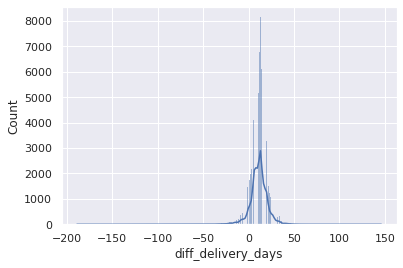

In [ ]:
print(orders['diff_delivery_days'].describe())
sns.histplot(x='diff_delivery_days', data=orders, kde=True)

Removeremos o valor máximo e mínimo da diferença.

In [ ]:
orders[(orders['diff_delivery_days'] > min(orders['diff_delivery_days'])) & (orders['diff_delivery_days'] < max(orders['diff_delivery_days'])) ]

order_id  ... diff_delivery_days
0       e481f51cbdc54678b7cc49136f2d6af7  ...                7.0
1       53cdb2fc8bc7dce0b6741e2150273451  ...                5.0
2       47770eb9100c2d0c44946d9cf07ec65d  ...               17.0
3       949d5b44dbf5de918fe9c16f97b45f8a  ...               12.0
4       ad21c59c0840e6cb83a9ceb5573f8159  ...                9.0
...                                  ...  ...                ...
112367  63943bddc261676b46f01ca7ac2f7bd8  ...                1.0
112368  83c1379a015df1e13d02aae0204711ab  ...                5.0
112369  11c177c8e97725db2631073c19f07b62  ...               20.0
112370  11c177c8e97725db2631073c19f07b62  ...               20.0
112371  66dea50a8b16d9b4dee7af250b4be1a5  ...               17.0

[110009 rows x 28 columns]

In [ ]:
orders_silver = orders.merge(order_items_silver,on='order_id',how='inner')

##Sazonalide e Tendência

In [ ]:
def plot_ts_decompose(decompose,figsize=(12,8)):
    fig, ax = plt.subplots(4,1,figsize=figsize)
    sns.lineplot(data=decompose.observed,x=decompose.observed.index,y=decompose.observed,ax=ax[0])
    sns.lineplot(data=decompose.trend,x=decompose.trend.index,y=decompose.trend,ax=ax[1])
    sns.lineplot(data=decompose.seasonal,x=decompose.seasonal.index,y=decompose.seasonal,ax=ax[2])
    sns.lineplot(data=decompose.resid,x=decompose.resid.index,y=decompose.resid,ax=ax[3])
    plt.tight_layout()

Como podemos perceber, existe uma sazonalidade na série em que nos meses de dezembro há queda na compra de produtos e nos meses de janeiro, março e maio há aumento. Outro fato da série é uma tendência a aumentar.

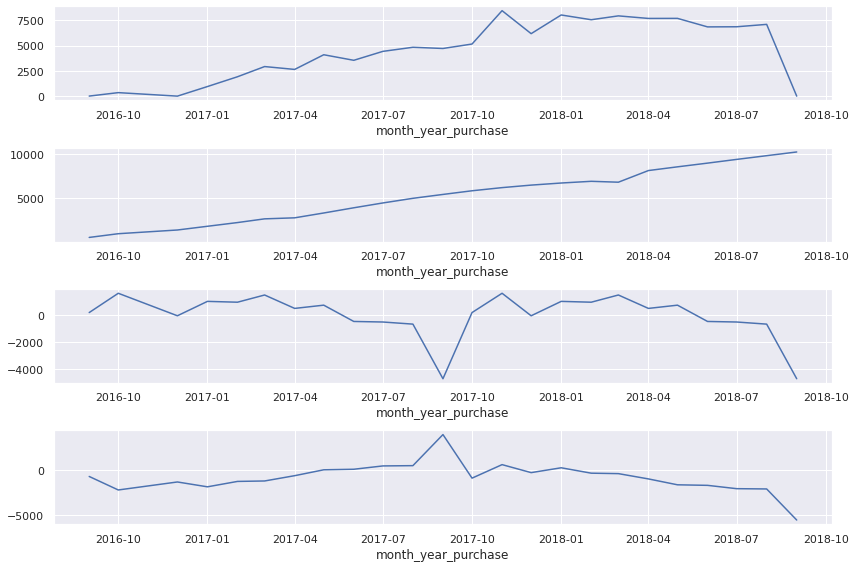

In [ ]:
orders_silver['month_year_purchase'] = orders_silver['order_purchase_timestamp'].dt.to_period('M')
order_purchase_timestamp = orders_silver.groupby('month_year_purchase').size()
order_purchase_timestamp.index = order_purchase_timestamp.index.astype('datetime64[ns]')

decompose = seasonal_decompose(order_purchase_timestamp,model='additive', freq=12, extrapolate_trend=12)
plot_ts_decompose(decompose)

In [ ]:
orders_customers = customers.merge(orders_silver, on='customer_id', how='inner')

In [ ]:
max_date = max(orders_customers['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [ ]:
orders_customers.head()

customer_id  ... month_year_purchase
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             2017-05
1  18955e83d337fd6b2def6b18a428ac77  ...             2018-01
2  4e7b3e00288586ebd08712fdd0374a03  ...             2018-05
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             2018-03
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             2018-07

[5 rows x 36 columns]

In [ ]:
#rfm_data = orders_customers.groupby('customer_unique_id').agg({
#    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
#    'customer_id':'count',
#    'price':'sum'
#}).reset_index()
#rfm_data.columns =['customer_id','recency','frequency','monetary']

In [ ]:
#se o comando acima der erro pode ser a coluna _x

rfm_data = orders_customers.groupby('customer_unique_id_x').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price_x':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

Observe que a frequência de clientes é o grande problema para a classificação, pois apenas 3% dos clientes fizeram mais de uma compra mas é algo muito comum no comércio eletrônico.

0.12084092920118122
count    93801.000000
mean         1.172130
std          0.576538
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64


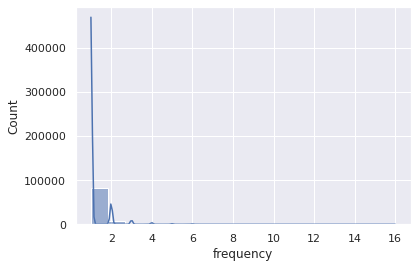

In [ ]:
print(rfm_data[rfm_data['frequency']>1].shape[0] / rfm_data.shape[0])
print(rfm_data['frequency'].describe())
sns.histplot(x='frequency', data=rfm_data, kde=True)

Um cliente monetário médio é R\$136 e 75% dos clientes gastam menos de R\$150 e o máximo foi R\$4690.

count    93801.000000
mean       136.980602
std        192.292749
min          0.850000
25%         47.000000
50%         89.000000
75%        150.000000
max       4690.000000
Name: monetary, dtype: float64


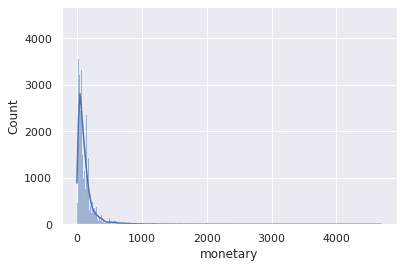

In [ ]:
print(rfm_data['monetary'].describe())
sns.histplot(x='monetary', data=rfm_data, kde=True)

Como podemos ver, 25% dos clientes têm uma recência de 3,9 meses com uma média de 8 meses. Com uma frequência de compra equivalente a 1 e com essa recência, isso indica que os clientes fazem compras muito específicas.

count    93801.00000
mean       243.69092
std        153.17850
min          1.00000
25%        120.00000
50%        224.00000
75%        353.00000
max        729.00000
Name: recency, dtype: float64


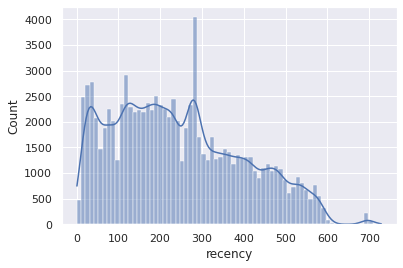

In [ ]:
print(rfm_data['recency'].describe())
sns.histplot(x='recency', data=rfm_data, kde=True)

##**Conclusões**

Visto que a maioria de nossos clientes não são recorrentes, não podemos realizar uma análise de coorte adequada sobre retenção e outras métricas possíveis.

Felizmente, podemos analisar a dinâmica do negócio e talvez seremos até capazes de identificar alguns grupos relativamente bons que podem ser usados como um protótipo (por exemplo, por profissionais de marketing).

A figura acima revela a dinâmica da Receita e Número de Clientes por coorte.

No lado esquerdo podemos ver o gráfico de receita e no lado direito podemos ver o gráfico ClientsCount.

No geral, podemos chegar às próximas conclusões:
* a dinâmica de dois gráficos é quase idêntica. Assim, parece que o valor médio do pedido foi o mesmo quase para cada coorte. Isso pode significar que a única maneira de obter mais receita é obter mais clientes. Além disso, sabemos que temos 97% de clientes não recorrentes, portanto, talvez resolver esse problema e estimular os clientes a voltar também resultaria em aumento de receita

* Suspeito que não temos os dados completos dos últimos meses, porque podemos ver uma queda anormal. Portanto, esses últimos meses não devem ser levados em consideração

* A coorte de novembro de 2017 parece fora de tendência, uma vez que esta coorte apresentou resultados excelentes. Pode ser devido às vendas da Black Friday que costumam acontecer em novembro, ou talvez durante o mês de novembro de 2017 algumas campanhas experimentais de marketing foram realizadas que levaram a bons resultados. Assim, esta coorte deve ser investigada pela empresa a fim de identificar o motivo de tal resultado marcante, e levá-lo em consideração

Como foi apontado acima, a ordem média é a mesma para quase todas as coortes. Mas temos alguns valores discrepantes que estão localizados no início e no final do gráfico à esquerda. Esses valores discrepantes provavelmente devem ser ignorados e podemos assumir que o valor médio do pedido é o mesmo para cada coorte. Assim, pode implicar que a empresa deva trabalhar para aumentar o número de clientes

<a id='data_insights'> </a>

**Conclusões Análise de Dados:**
* Existem mais clientes nas regiões sudeste e sul do país. Outras informações, há mais clientes em cidades que são capitais (São Paulo, Rio de Janeiro, Porto Alegre e outras);
* O preço médio dos pedidos é de R\$132 e 50% dos pedidos custam menos de R\$85. O valor médio do frete é de R\$21,41 e 50% dos pedidos têm o valor do frete de R\$17;
* A data de entrega precisa ser revisada porque a diferença média entre a entrega estimada e a real é de 10 dias, o que é um pouco alto. Outro fato é que apenas 7,81% da entrega real foi inferior à entrega estimada;
* Existe uma série sazonal de compras em que nos meses de dezembro há queda na compra de produtos e nos meses de janeiro, março e maio há aumento;
* Apenas 3% dos clientes realizaram mais de uma compra;
* Um cliente monetário médio é R\$136 e 75% dos clientes gastam menos de R\$150 e o máximo é R\$4690;
* Os 25% dos clientes têm uma recência de 3,9 meses com uma média de 8 meses. Com uma frequência de compra equivalente a 1 e com essa recência, isso indica que os clientes fazem compras muito específicas.

<a name='pontuacao'> </a>
# Análise RFM - Pontuação

Como algoritmo foi utilizado o RFM, por ser um modelo de fácil compreensão.

O termo RFM vem da junção de três siglas: Recência, Frequência e Monetária, buscando entender melhor o cliente e verificar quando foi sua última compra, quantas vezes ele comprou e quanto gastou com a empresa.

Tempo para retorno (R) dias desde a última compra do cliente.

Frequência (F) Número de produtos comprados pelo cliente.

Monetaridade (M) Total gasto em compras.

**Pontuação do cliente:**

A pontuação do cliente varia de 1 a 5, sendo que quanto maior esse número, melhor. Esta pontuação é atribuída para cada acrônimo de forma independente:

* Quanto mais recente for a compra do cliente, maior será a pontuação de Recência (R).
* Quanto mais compras o cliente fizer, maior será a pontuação de Frequência (F)
* Quanto mais o cliente gasta em compras, maior será a pontuação Monetária (M)

Essa definição de cada pontuação pode ser dada por inferência, ou seja, alguma definição de negócio ou por quintil.


#### **Cálculo de segmentação:**

O cálculo para saber em qual segmentação o cliente está é dado pela média das pontuações F e M e o valor R separado.

| Nome do segmento | Faixa de valores R | Variação da média de F e M |
| ---------------------------- | ------------------- | -------------------------- |
| Campeões | 4 - 5 | 4 - 5 |
| Clientes leais | 2 - 5 | 3 - 5 |
| Potencial de Fifelidade | 3 - 5 | 1 - 3 |
| Novos clientes | 4 - 5 | 0 - 1 |
| Promissor | 3 - 4 | 0 - 1 |
| Clientes que precisam de atenção | 2 - 3 | 2 - 3 |
| Prestes a dormir | 2 - 3 | 0 - 2 |
| Em risco | 0 - 2 | 2 - 5 |
| Não podemos perdê-los | 0 - 1 | 4 - 5 |
| Hibernando | 1 - 2 | 1 - 2 |
| Perdido | 0 - 2 | 0 - 2 |

Temos apenas 3% dos clientes que fizeram mais de uma compra, ou seja, temos dados distorcidos. Para este problema, usamos o algoritmo k-means para agrupar os dados de acordo com suas características semelhantes.

##**Desenvolvendo o Modelo de Machine Learning - KMeans**

In [ ]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

**Aplicando O Método Elbow**

In [ ]:
# Selecionando o número de clusters através do método Elbow (Soma das distâncias quadráticas intra clusters):
X2 = rfm_data[['monetary']].iloc[:].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n))
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

**Visualizando as Distâncias Intra Clusters**

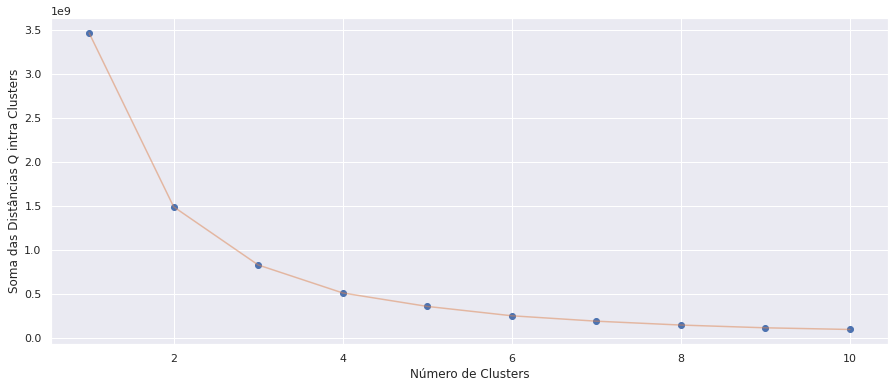

In [ ]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters') , plt.ylabel('Soma das Distâncias Q intra Clusters')
plt.show()

**Vamos utilizar o Número de Clusters=5 e random_state=1**

In [ ]:
num_clusters = 5
random_state = 1

**Aplicando o Kmeans para o R, F e M**

In [ ]:
r_labels = k_means_group(rfm_data[['recency']],num_clusters,random_state,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],num_clusters,random_state)
m_labels = k_means_group(rfm_data[['monetary']],num_clusters,random_state)

rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels) 

Como podemos ver, a maioria dos clientes tem um tempo de retorno entre 5 a 8 meses.

In [ ]:
rfm_data.groupby('R')['recency'].describe()

count        mean        std    min    25%    50%    75%    max
R                                                                   
1  12062.0  515.174847  50.141655  448.0  475.0  508.0  546.0  729.0
2  15429.0  381.630955  35.157935  323.0  351.0  381.0  411.0  447.0
3  22157.0  264.747033  30.724944  212.0  236.0  269.0  286.0  322.0
4  24369.0  157.669293  30.929346  106.0  130.0  158.0  185.0  211.0
5  19784.0   52.971391  27.457100    1.0   29.0   49.0   77.0  105.0

Apenas 3% dos clientes fizeram mais de uma compra, mas é algo muito comum no comércio eletrônico.

In [ ]:
rfm_data.groupby('F')['frequency'].describe()

count       mean       std  min  25%   50%   75%   max
F                                                          
1  82466.0   1.000000  0.000000  1.0  1.0   1.0   1.0   1.0
2   8563.0   2.000000  0.000000  2.0  2.0   2.0   2.0   2.0
3   2299.0   3.270552  0.444342  3.0  3.0   3.0   4.0   4.0
4    440.0   5.622727  0.792006  5.0  5.0   5.0   6.0   8.0
5     33.0  10.969697  2.023068  9.0  9.0  10.0  12.0  16.0

Como podemos observar, a maioria dos clientes possui um valor monetário médio de R\$58,29. O que não é muito bom para os negócios porque quanto maior, melhor.

In [ ]:
rfm_data.groupby('M')['monetary'].describe()

count         mean         std      min      25%      50%      75%     max
M                                                                              
1  62066.0    61.118885   31.397509     0.85    34.90    57.49    88.00   123.4
2  24380.0   185.768884   49.483741   123.43   146.00   172.89   219.00   315.7
3   5657.0   446.097313  109.972634   315.79   349.99   399.99   527.90   712.5
4   1397.0   980.557810  215.018149   712.90   799.00   899.99  1129.99  1535.4
5    301.0  2103.174751  580.310253  1549.00  1699.00  1970.00  2258.00  4690.0

In [ ]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Campeões'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Clientes Fiéis'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Potencial de Fidelidade'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Novos Clientes'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promissor'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Clientes que precisam de atenção'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'Prestes a Dormir'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'Em Risco'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Não Podemos Perdê-los"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Hibernando'
    return 'Perdido'

In [ ]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

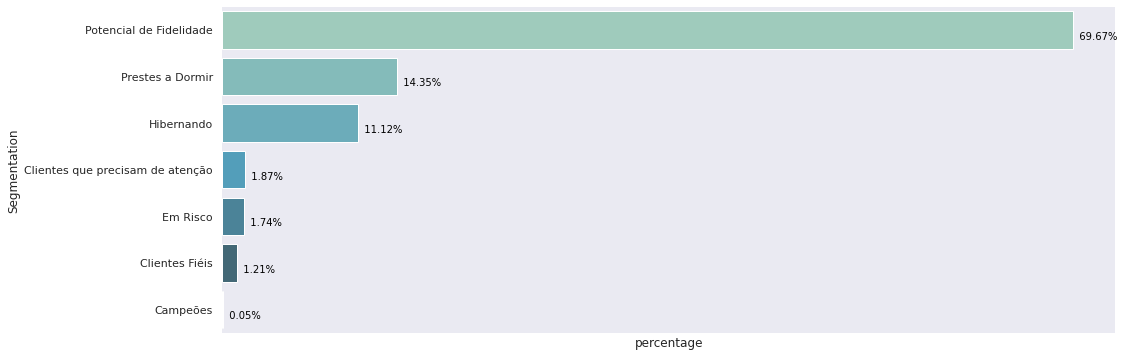

In [ ]:
plt.figure(figsize=(16,6))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

## **Conclusões:**

** 69,67% - Lista de Potencial de Fidelidade: **

São compradores recentes, gastam uma boa quantia e compraram mais de uma vez.

<u> Estratégia de CRM </u>:

* Oferecer um programa de fidelidade;
* Mantenha-os engajados;
* Recomendações personalizadas e outras recomendações de produtos.

** 14,35% - Prestes a dormir: **

São clientes que não compram há muito tempo, mas ainda podem comprar novamente.

<u> Estratégia de CRM </u>:

* Oferecer descontos;
* Recomendação de produtos populares.

** 11,12% - Hibernando: **

São clientes que compraram há muito tempo, apenas algumas vezes e gastaram pouco

<u> Estratégia de CRM </u>:

* Comunicação padrão para envio de ofertas;
* Ofereça produtos relevantes e bons negócios.

** 1,87% - Atenção necessária ao cliente: **

São clientes que compraram recentemente, mas ainda têm dúvidas se farão a próxima compra da empresa ou de um concorrente.

<u> Estratégia de CRM </u>:

* Campanhas promocionais por tempo limitado;
* Recomendações de produtos com base em seu comportamento;
* Mostre a importância de comprar com a empresa.

** 1,74% - Em risco: **

São clientes que gastam muito pouco dinheiro e compram com frequência, mas não compram há muito tempo

<u> Estratégia de CRM </u>:

* Envie comunicações personalizadas e outras mensagens para se reconectar;
* Ofereça bons negócios.

** 1,21% - Clientes Fiéis: **

São clientes que gastam bem e com frequência.

<u> Estratégia de CRM </u>:

* Comunicação personalizada;
* Evite o envio em massa de ofertas;
* Ofereça poucos produtos, mas apresente produtos nos quais eles provavelmente tenham interesse;
* Peça análises de produtos.

** 0,05% - Campeões: **

São clientes que compraram recentemente, compram com frequência e gastam muito.

<u> Estratégia de CRM </u>:

* Ofertas, produtos e descontos especiais para estes clientes para que se sintam valorizados;
* Peça opiniões e feedbacks constantemente;
* Evite enviar grandes quantidades de ofertas;
* Comunicação personalizada;
* Dê recompensas.


<a name='segmentos'></a>
# Análise RFM - Segmentos

Usei quantis para atribuir pontuações para Recência e Monetária.
* grupos são 0-33, 33-66, 66-100 quantis

Para Frequência, decidi agrupá-los manualmente
* pontuação = 1 se o valor da frequência for 1
* caso contrário, a pontuação será 2

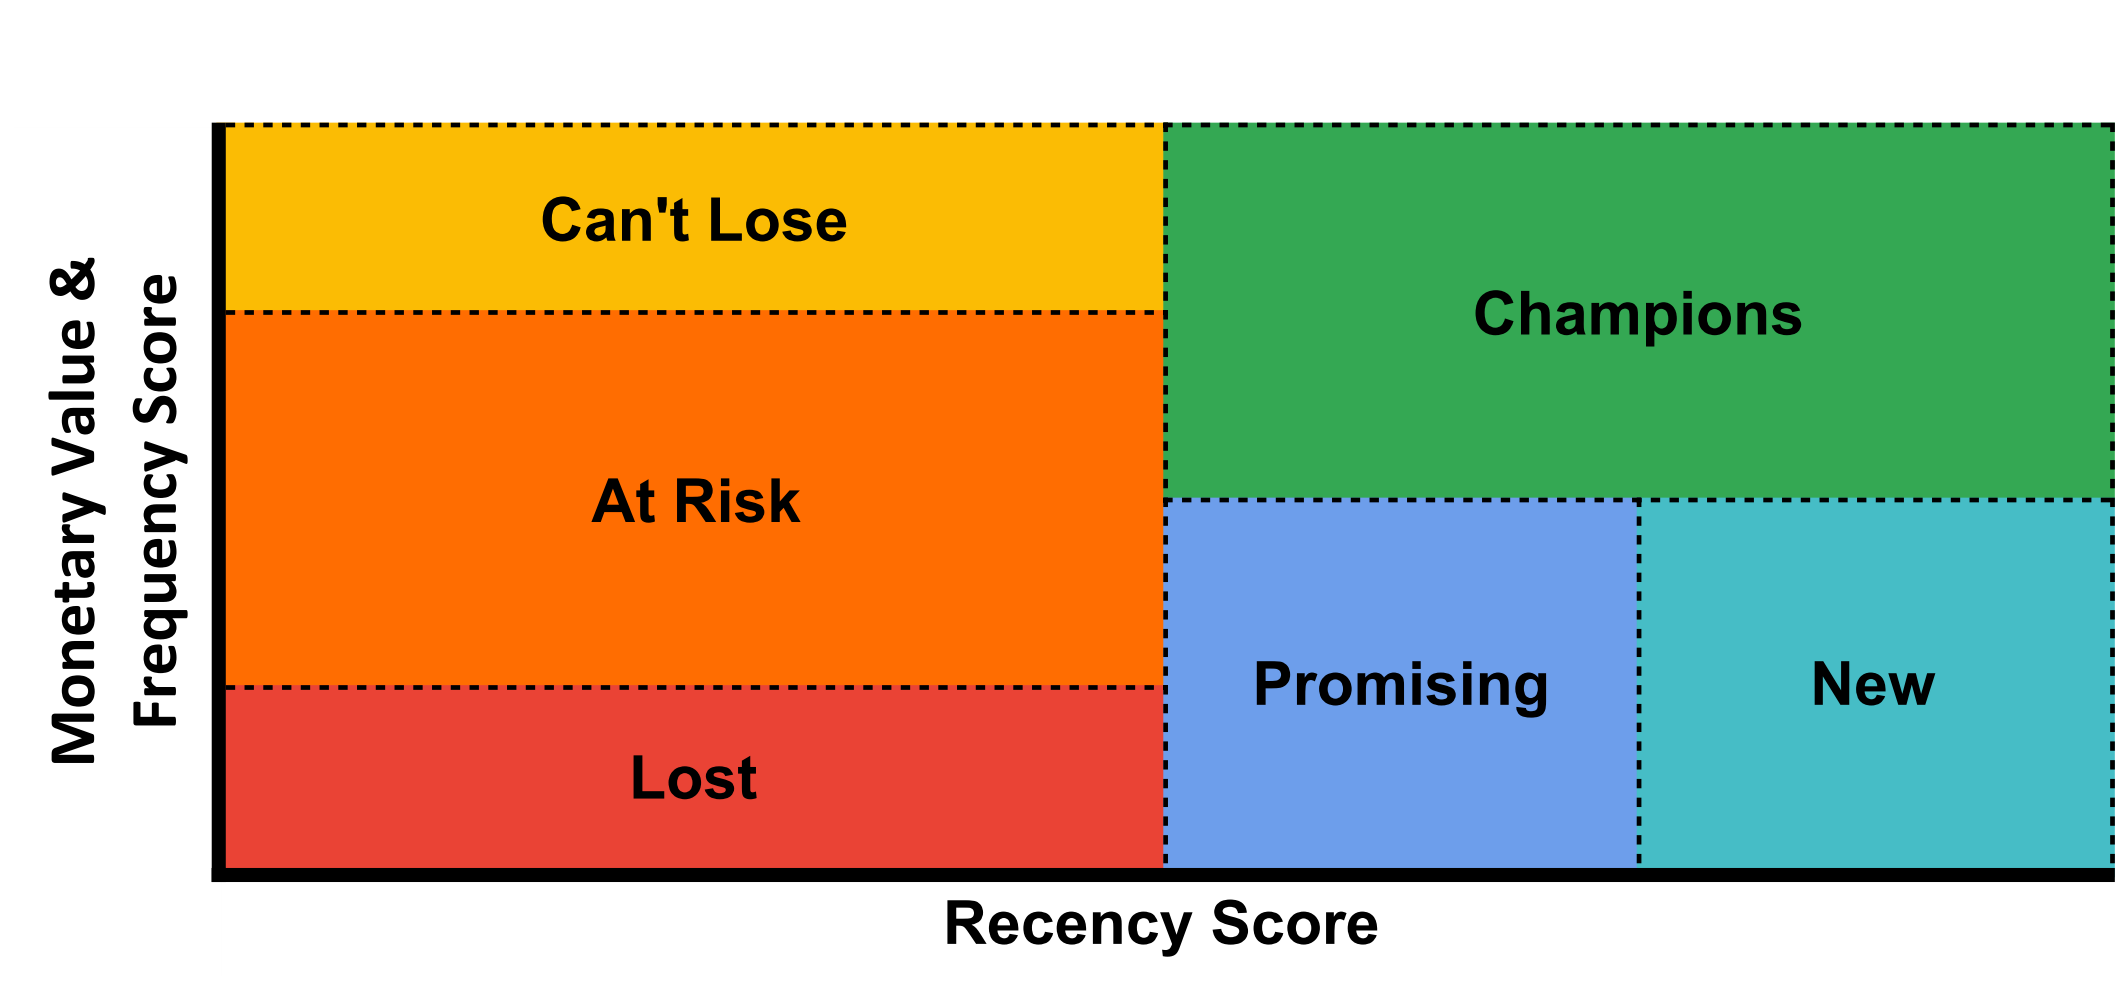

**Perfis dos segmentos:**

1. **PRINCIPAL** - '123' - mais recente, frequente, gerador de receitas - clientes principais que devem ser considerados clientes mais valiosos
2. **PERDIDO** - '311', '312', '313' - desaparecido, one-timers - esses clientes provavelmente sumiram;
3. **INICIANTE** - '111', '112', '113' - acabou de se inscrever - novos clientes que se inscreveram recentemente
4. **BALEIA** - '323', '213', '223 - maior geração de receita - baleias que geram receita
5. **FIEL** - '221', '222', '321', '322' - usuários leais
6. **REGULAR** - '121', '122', '211', '212', - usuários médios - apenas clientes regulares que não se destacam

A tarefa é realizar a análise RFM.
* __olist_orders_dataset.csv__ e __olist_order_payments_dataset.csv__ devem ser usados
* order_delivered_carrier_date - deve ser usado nesta tarefa
* Uma vez que o conjunto de dados não é real em 2021, devemos supor que fomos solicitados a realizar a análise RFM no dia seguinte ao último registro

## Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

## Carregando os dados

In [ ]:
orders = pd.read_csv(path_relativo + '/database/olist_orders_dataset.csv')
payments = pd.read_csv(path_relativo + '/database/olist_order_payments_dataset.csv')

## Unificando os dados

In [ ]:
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date']) # datetime conversion
payments = payments.set_index('order_id') # preparation before the join
orders = orders.set_index('order_id') # preparation before the join

joined = orders.join(payments) # join on order_id

In [ ]:
joined.isna()\
      .sum()\
      .sort_values(ascending=False)

order_delivered_customer_date    3132
order_delivered_carrier_date     1888
order_approved_at                 175
payment_value                       1
payment_installments                1
payment_type                        1
payment_sequential                  1
order_estimated_delivery_date       0
order_purchase_timestamp            0
order_status                        0
customer_id                         0
dtype: int64

In [ ]:
joined.nunique()\
      .sort_values(ascending=False)

customer_id                      99441
order_purchase_timestamp         98875
order_delivered_customer_date    95664
order_approved_at                90733
order_delivered_carrier_date     81018
payment_value                    29077
order_estimated_delivery_date      459
payment_sequential                  29
payment_installments                24
order_status                         8
payment_type                         5
dtype: int64

Parece que faltam valores. E, infelizmente, order_delivered_carrier_date também tem valores ausentes. Portanto, eles devem ser descartados

In [ ]:
last_date = joined['order_delivered_carrier_date'].max() + pd.to_timedelta(1, 'D')

RFM = joined.dropna(subset=['order_delivered_carrier_date'])\
            .reset_index()\
            .groupby('customer_id')\
            .agg(Recency = ('order_delivered_carrier_date', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'))

Verificação de integridade - temos valores NaN ou não?

In [ ]:
RFM.isna().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [ ]:
RFM.describe([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

count        mean         std  ...      95%        99%       max
Recency    97658.0  250.511847  152.674579  ...  532.000   587.0000    704.00
Frequency  97658.0    1.044451    0.378736  ...    1.000     2.0000     29.00
Monetary   97658.0  159.824647  218.553380  ...  446.558  1048.6658  13664.08

[3 rows x 14 columns]

Então, aqui podemos ver que temos alguns outliers nos grupos de frequência e monetário. Assim, eles devem ser descartados e analisados separadamente

## Recência

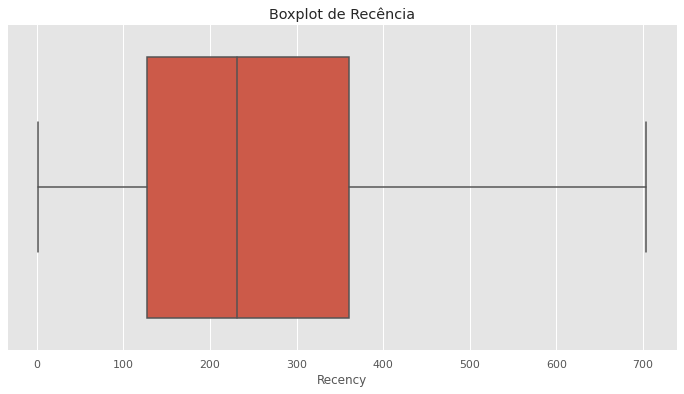

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Recency', data=RFM)
plt.title('Boxplot de Recência');

## Frequência

In [ ]:
RFM['Frequency'].value_counts(normalize=True)*100

1     97.025333
2      2.395093
3      0.303099
4      0.108542
5      0.053247
6      0.035839
7      0.028671
8      0.010240
12     0.008192
11     0.008192
9      0.007168
10     0.003072
13     0.003072
14     0.002048
15     0.002048
19     0.002048
26     0.001024
21     0.001024
22     0.001024
29     0.001024
Name: Frequency, dtype: float64

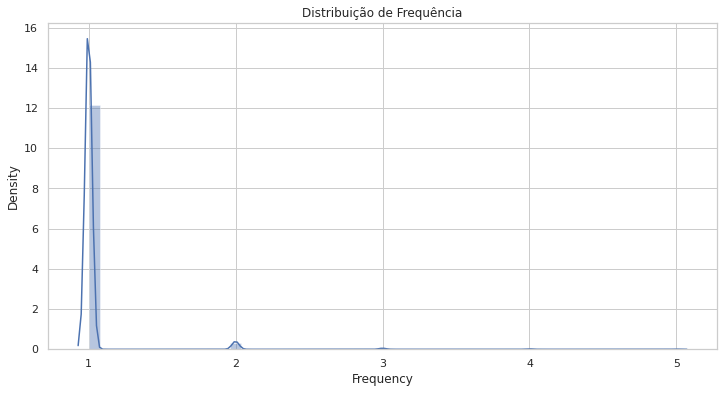

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Distribuição de Frequência')
sns.distplot(RFM['Frequency']);

Eu acho que aqui devemos selecionar apenas valores de frequência maiores que 5, porque, ao fazer isso, apenas diminuímos 0,11% dos registros

In [ ]:
RFM['Frequency'].apply(lambda x: 'less or equal to 5' if x<=5 else 'greater than 5')\
                .value_counts(normalize=True) * 100

less or equal to 5    99.885314
greater than 5         0.114686
Name: Frequency, dtype: float64

In [ ]:
RFM = RFM[RFM['Frequency'] <= 5]

## Monetária

In [ ]:
RFM['Monetary'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    97546.000000
mean       159.780566
std        218.510326
min          0.000000
25%         61.880000
50%        105.280000
75%        176.255000
90%        305.680000
95%        446.215000
99%       1048.570000
max      13664.080000
Name: Monetary, dtype: float64

Aqui, parece que o percentil 95% deve ser usado para eliminar os valores discrepantes

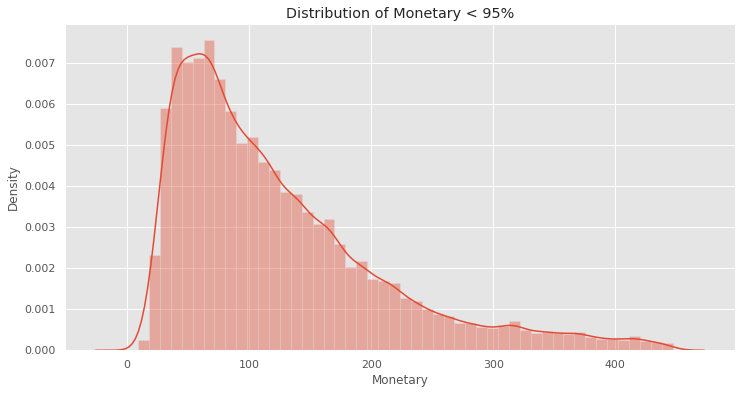

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of Monetary < 95%')
sns.distplot(RFM[RFM['Monetary']<447].Monetary);

In [ ]:
RFM = RFM[RFM['Monetary'] < 447]

In [ ]:
RFM['R_score'] = pd.qcut(RFM['Recency'], 3, labels=[1, 2, 3]).astype(str)
RFM['M_score'] = pd.qcut(RFM['Monetary'], 3, labels=[1, 2, 3]).astype(str)
RFM['F_score'] = RFM['Frequency'].apply(lambda x: '1' if x==1 else '2')

RFM['RFM_score'] = RFM['R_score'] + RFM['F_score'] + RFM['M_score']

In [ ]:
def segment(x):
    if x == '123':
        return 'Principal'
    elif x in ['311', '312', '313']:
        return 'Perdido'
    elif x in ['111', '112', '113']:
        return 'Iniciante'
    elif x in ['323', '213', '223']:
        return 'Baleia'
    elif x in ['221', '222', '321', '322']:
        return 'Fiel'
    else:
        return 'Regular'

In [ ]:
RFM['segments'] = RFM['RFM_score'].apply(segment)
RFM['segments'].value_counts(normalize=True)*100

Iniciante    32.547099
Perdido      32.028097
Regular      22.199443
Baleias      11.516217
Fiel          1.440471
Principal     0.268672
Name: segments, dtype: float64

In [ ]:
segmentwise = RFM.groupby('segments').agg(RecencyMean = ('Recency', 'mean'),
                                          FrequencyMean = ('Frequency', 'mean'),
                                          MonetaryMean = ('Monetary', 'mean'),
                                          GroupSize = ('Recency', 'size'))
segmentwise

RecencyMean  FrequencyMean  MonetaryMean  GroupSize
segments                                                      
Baleias     238.460695       1.062307    220.948326      10673
Fiel        345.632210       2.262921     73.224195       1335
Iniciante    88.471058       1.000000    124.585984      30164
Perdido     431.335613       1.000000    122.264921      29683
Principal    86.939759       2.220884    221.581847        249
Regular     229.625061       1.031302     74.299787      20574

##Representação dos Segmentos

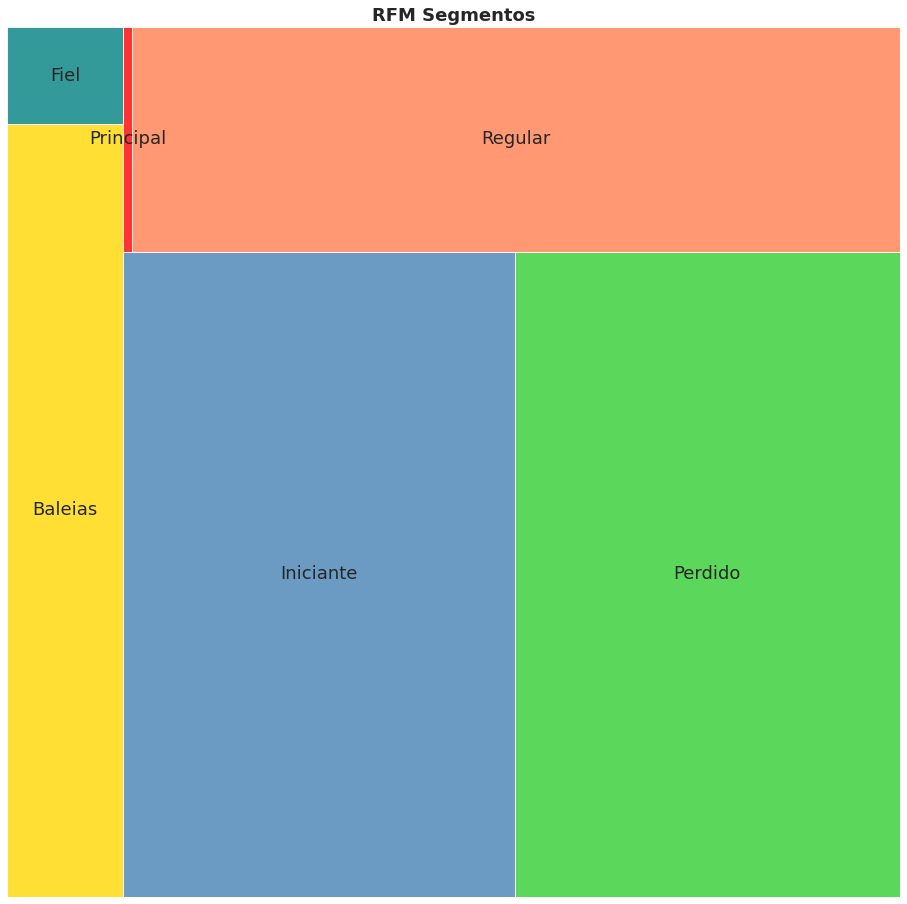

In [ ]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 16)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['gold', 'teal', 'steelblue', 'limegreen', 'red', 'coral'],
              alpha = 0.8)
plt.title("RFM Segmentos",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

Cauda Longa - Conceito e link

Marketing - Novos Clientes

<a name='fidelidade'></a>
# **Análise RFM - Plano de Fidelidade**

In [ ]:
#Importa as bibiliotecas
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
Rtl_data = pd.read_csv(path_relativo + 'database/olist_order_items_dataset.csv')
Rtl_data.head()

order_id  order_item_id  ...   price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2  000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3  00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14

[5 rows x 7 columns]

In [ ]:
df_orders = pd.read_csv(path_relativo + 'database/olist_orders_dataset.csv')

In [ ]:
Rtl_data.head()

order_id  order_item_id  ...   price freight_value
0  00010242fe8c5a6d1ba2dd792cb16214              1  ...   58.90         13.29
1  00018f77f2f0320c557190d7a144bdd3              1  ...  239.90         19.93
2  000229ec398224ef6ca0657da4fc703e              1  ...  199.00         17.87
3  00024acbcdf0a6daa1e931b038114c75              1  ...   12.99         12.79
4  00042b26cf59d7ce69dfabb4e55b4fd9              1  ...  199.90         18.14

[5 rows x 7 columns]

In [ ]:
Rtl_data = pd.merge(Rtl_data, df_orders, on=["order_id"], how="inner")
Rtl_data.head()

order_id  ...  order_estimated_delivery_date
0  00010242fe8c5a6d1ba2dd792cb16214  ...            2017-09-29 00:00:00
1  00018f77f2f0320c557190d7a144bdd3  ...            2017-05-15 00:00:00
2  000229ec398224ef6ca0657da4fc703e  ...            2018-02-05 00:00:00
3  00024acbcdf0a6daa1e931b038114c75  ...            2018-08-20 00:00:00
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...            2017-03-17 00:00:00

[5 rows x 14 columns]

In [ ]:
fields = ['order_id', 'product_id', 'price', 'order_purchase_timestamp', 'customer_id']
Rtl_data = Rtl_data[fields]

In [ ]:
Rtl_data.shape

(112650, 5)

In [ ]:
Rtl_data.isnull().sum(axis=0)

order_id                    0
product_id                  0
price                       0
order_purchase_timestamp    0
customer_id                 0
dtype: int64

In [ ]:
fields_renamed = ['InvoiceNo', 'StockCode', 'UnitPrice', 'InvoiceDate', 'CustomerID']
Rtl_data.columns = fields_renamed
Rtl_data.head()

InvoiceNo  ...                        CustomerID
0  00010242fe8c5a6d1ba2dd792cb16214  ...  3ce436f183e68e07877b285a838db11a
1  00018f77f2f0320c557190d7a144bdd3  ...  f6dd3ec061db4e3987629fe6b26e5cce
2  000229ec398224ef6ca0657da4fc703e  ...  6489ae5e4333f3693df5ad4372dab6d3
3  00024acbcdf0a6daa1e931b038114c75  ...  d4eb9395c8c0431ee92fce09860c5a06
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...  58dbd0b2d70206bf40e62cd34e84d795

[5 rows x 5 columns]

In [ ]:
Rtl_data['InvoiceDate'] = pd.to_datetime(Rtl_data['InvoiceDate'])

In [ ]:
Rtl_data['TotalAmount'] = Rtl_data['UnitPrice']

In [ ]:
Rtl_data.shape

(112650, 6)

In [ ]:
Rtl_data.head()

InvoiceNo  ... TotalAmount
0  00010242fe8c5a6d1ba2dd792cb16214  ...       58.90
1  00018f77f2f0320c557190d7a144bdd3  ...      239.90
2  000229ec398224ef6ca0657da4fc703e  ...      199.00
3  00024acbcdf0a6daa1e931b038114c75  ...       12.99
4  00042b26cf59d7ce69dfabb4e55b4fd9  ...      199.90

[5 rows x 6 columns]

## RFM - Modelagem

In [ ]:
Rtl_data.InvoiceDate.max()

Timestamp('2018-09-03 09:06:57')

In [ ]:
import datetime as dt

Latest_Date = dt.datetime(2011,9,3)

RFMScores = Rtl_data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalAmount': lambda x: x.sum()})

RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalAmount': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

CustomerID  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703    -2265          1     89.80
1  000161a058600d5901f007fab4c27140    -2144          1     54.90
2  0001fd6190edaaf884bcaf3d49edf079    -2006          1    179.99
3  0002414f95344307404f0ace7a26f1d5    -2175          1    149.90
4  000379cdec625522490c315e70c7a9fb    -2404          1     93.00

In [ ]:
RFMScores.Recency.describe()

count    98666.000000
mean     -2312.283928
std        153.392934
min      -2558.000000
25%      -2436.000000
50%      -2331.000000
75%      -2202.000000
max      -1829.000000
Name: Recency, dtype: float64

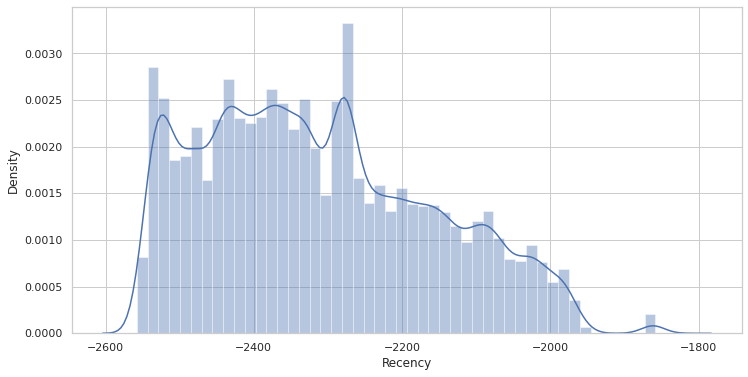

In [ ]:
import seaborn as sns
x = RFMScores['Recency']

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.figure(figsize=(12, 6))


ax = sns.distplot(x)

In [ ]:
RFMScores.Frequency.describe()

count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: Frequency, dtype: float64

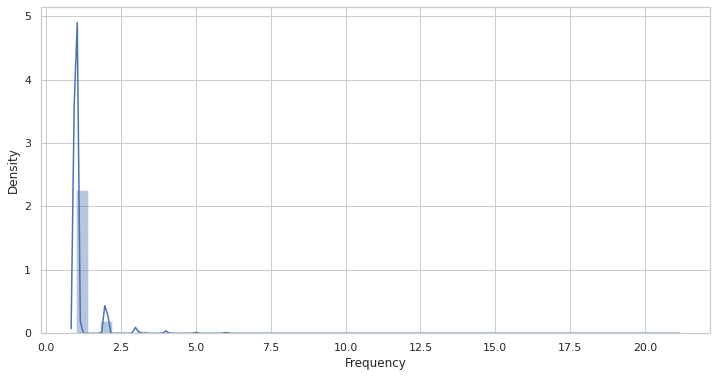

In [ ]:
import seaborn as sns
x = RFMScores.query('Frequency < 1000')['Frequency']
plt.figure(figsize=(12, 6))

ax = sns.distplot(x)

In [ ]:
RFMScores.Monetary.describe()

count    98666.000000
mean       137.754076
std        210.645145
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: Monetary, dtype: float64

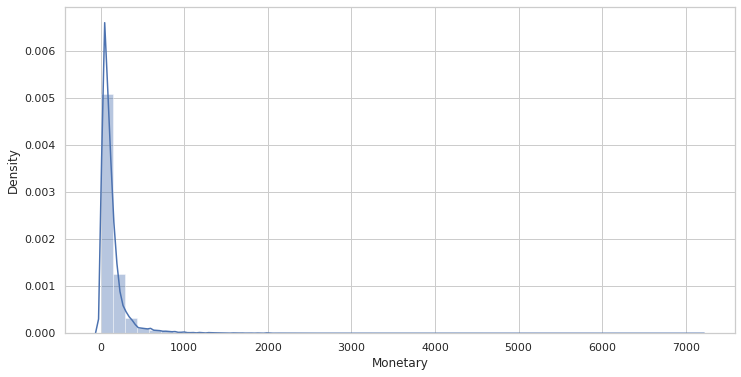

In [ ]:
import seaborn as sns
x = RFMScores.query('Monetary < 10000')['Monetary']
plt.figure(figsize=(12, 6))

ax = sns.distplot(x)

In [ ]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 45.9, 0.5: 86.9, 0.75: 149.9},
 'Recency': {0.25: -2436.0, 0.5: -2331.0, 0.75: -2202.0}}

In [ ]:
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

Recency  Frequency  Monetary  R  F  M
CustomerID                                                             
00012a2ce6f8dcda20d059ce98491703    -2265          1     89.80  3  4  2
000161a058600d5901f007fab4c27140    -2144          1     54.90  4  4  3
0001fd6190edaaf884bcaf3d49edf079    -2006          1    179.99  4  4  1
0002414f95344307404f0ace7a26f1d5    -2175          1    149.90  4  4  2
000379cdec625522490c315e70c7a9fb    -2404          1     93.00  2  4  2

In [ ]:
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

Recency  Frequency  ...  RFMGroup  RFMScore
CustomerID                                            ...                    
00012a2ce6f8dcda20d059ce98491703    -2265          1  ...       342         9
000161a058600d5901f007fab4c27140    -2144          1  ...       443        11
0001fd6190edaaf884bcaf3d49edf079    -2006          1  ...       441         9
0002414f95344307404f0ace7a26f1d5    -2175          1  ...       442        10
000379cdec625522490c315e70c7a9fb    -2404          1  ...       242         8

[5 rows x 8 columns]

In [ ]:
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

CustomerID  Recency  ...  RFMScore  RFM_Loyalty_Level
0  00012a2ce6f8dcda20d059ce98491703    -2265  ...         9               Gold
1  000161a058600d5901f007fab4c27140    -2144  ...        11             Bronze
2  0001fd6190edaaf884bcaf3d49edf079    -2006  ...         9               Gold
3  0002414f95344307404f0ace7a26f1d5    -2175  ...        10             Silver
4  000379cdec625522490c315e70c7a9fb    -2404  ...         8           Platinum

[5 rows x 10 columns]

In [ ]:
# Validando a categoria Platinum
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

CustomerID  Recency  ...  RFMScore  RFM_Loyalty_Level
0  ec5b2ba62e574342386871631fafd3fc    -2508  ...         3           Platinum
1  e0a2412720e9ea4f26c1ac985f6a7358    -2505  ...         3           Platinum
2  cc803a2c412833101651d3f90ca7de24    -2463  ...         3           Platinum
3  a7ea318cbe9df2ec79ab37cd7ca2135d    -2470  ...         3           Platinum
4  71901689c5f3e5adc27b1dd16b33f0b8    -2454  ...         3           Platinum
5  6152fbfc8a92ee25fd821740bd33b089    -2474  ...         3           Platinum
6  f7622098214b4634b7fe7eee269b5426    -2464  ...         3           Platinum
7  53e644c7c57416bdaf0409e656ee8b0a    -2464  ...         3           Platinum
8  7e95832184f874c220b8ebffa750837d    -2443  ...         3           Platinum
9  b9da524b08224eaff1bf76ef4d4299ac    -2457  ...         3           Platinum

[10 rows x 10 columns]

##**Gráfico de Barras das Categorias**

In [ ]:
RFMScores.reset_index()

CustomerID  Recency  ...  RFMScore  RFM_Loyalty_Level
0      00012a2ce6f8dcda20d059ce98491703    -2265  ...         9               Gold
1      000161a058600d5901f007fab4c27140    -2144  ...        11             Bronze
2      0001fd6190edaaf884bcaf3d49edf079    -2006  ...         9               Gold
3      0002414f95344307404f0ace7a26f1d5    -2175  ...        10             Silver
4      000379cdec625522490c315e70c7a9fb    -2404  ...         8           Platinum
...                                 ...      ...  ...       ...                ...
98661  fffcb937e9dd47a13f05ecb8290f4d3e    -2388  ...         9               Gold
98662  fffecc9f79fd8c764f843e9951b11341    -2400  ...         9               Gold
98663  fffeda5b6d849fbd39689bb92087f431    -2454  ...         8           Platinum
98664  ffff42319e9b2d713724ae527742af25    -2476  ...         6           Platinum
98665  ffffa3172527f765de70084a7e53aae8    -2192  ...         9               Gold

[98666 rows x 10 columns]

In [ ]:
RFMScores['unity'] = 1

In [ ]:
s = RFMScores.groupby(['RFM_Loyalty_Level'])['unity'].sum()
s.reset_index()

df_categories = pd.DataFrame(s).reset_index()
df_categories.columns = ['RFM_Loyalty_Level', 'Count']
df_categories

RFM_Loyalty_Level  Count
0          Platinum  41698
1              Gold  22320
2            Silver  17183
3            Bronze  17465

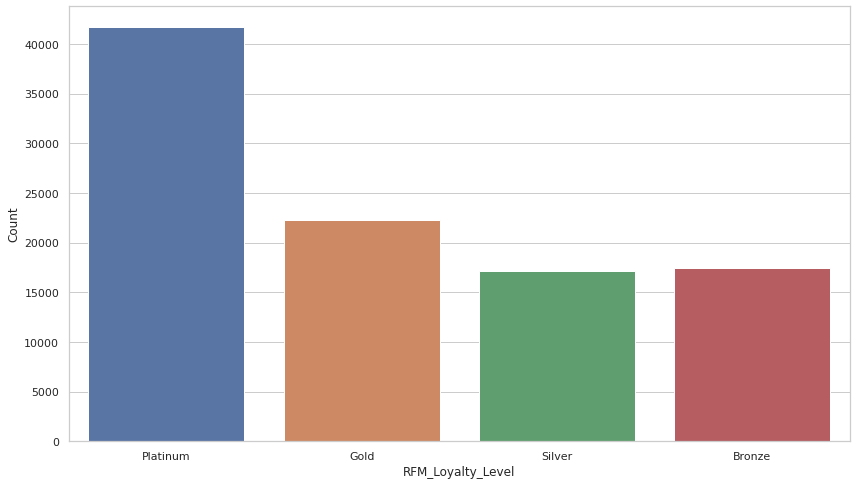

In [ ]:
import seaborn as sns
plt.figure(figsize=(14, 8))

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="RFM_Loyalty_Level", y="Count", data=df_categories)

<a name='plot3d'></a>
#**Análise RFM - Plotando em 3D**

In [ ]:
import plotly.express as px

fig = px.scatter_3d(RFMScores, x='R', y='F', z='M',
              color='RFM_Loyalty_Level')
fig.show()

##**Plot 3D - Agora com mais detalhes**


In [ ]:
import plotly.express as px

fig = px.scatter_3d(RFMScores, x='Recency', y='Frequency', z='Monetary',
              color='RFM_Loyalty_Level', size='RFMScore', size_max=18,
              opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

<a name='referencias'></a>
# Referências:

Este projeto foi feito com a colaboração de códigos-fontes abertos e análises de cientistas da comunidade de dados do mundo todo. 

Com destaque para as referências abaixo:

Formação Cientista de Dados - Stack tecnologias

https://stacktecnologias.com.br/

https://www.youtube.com/watch?v=VE0m2FLoJCk

https://www.youtube.com/watch?v=SrY0sTJchHE

https://www.kaggle.com/tiagodatascience/rfm-segmentation

https://www.kaggle.com/yacinerouizi/e-commerce-customer-segmentation

https://www.kaggle.com/ceruttivini/rfm-segmentation-and-customer-analysis/data

https://www.kaggle.com/andresionek/geospatial-analysis-of-brazilian-e-commerce/notebook

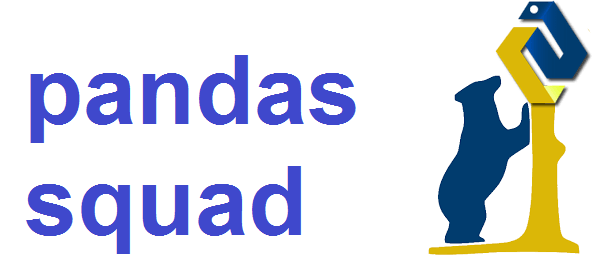
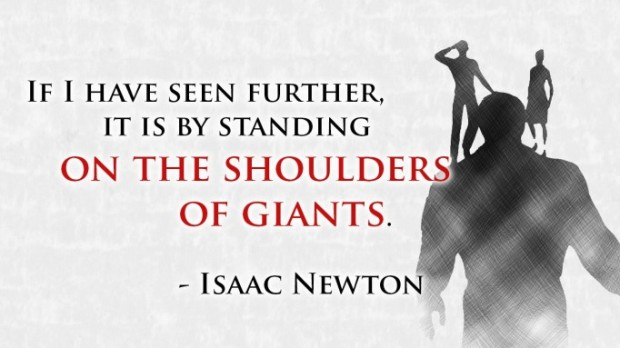



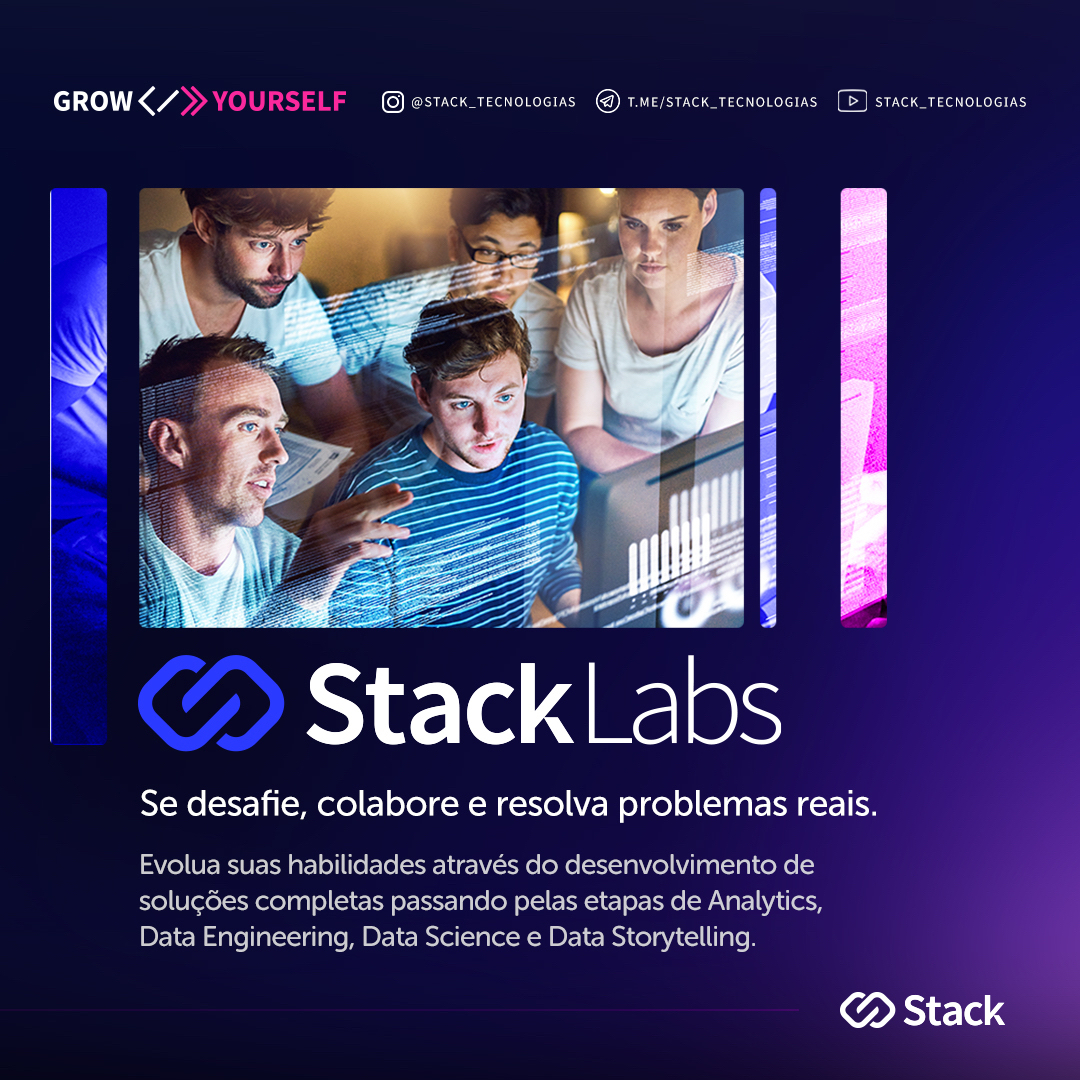